### Load Libraries & Packages

In [30]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import pickle
import matplotlib.pyplot as plt
import time

### Import Data and State-Space Model

In [31]:
with open('HW2_Data.pickle', 'rb') as f:
    Data = pickle.load(f)
Data.keys()

dict_keys(['Ti', 'To', 'q_solar'])

Extracts specific temperature and solar radiation data for a 2-day period, assuming 10-minute intervals between data points.

In [32]:
with open('HW2_Data.pickle', 'rb') as f:
    Data = pickle.load(f)
Ti = Data['Ti'][:6*24*2] # indoor air temperature in degC
To = Data['To'][:6*24*2] # outdoor air temperature in degC
q_solar = Data['q_solar'][:6*24*2] # absorbed solar radiation in W

# Loads a state-space model from a serialized pickle file and extracts specific matrices
with open('HW2_SS-Model.pickle', 'rb') as f:
    ss_model = pickle.load(f)
Ad = ss_model['Ad'] 
Bd = ss_model['Bd']
Cd = ss_model['Cd']
Dd = ss_model['Dd']
# add new Ed = -1/Ce*q_BH - 2/Ce*Ei + 1/Ce * q_GB 

Bd_HVAC = Bd[:,:1]
Bd_dist = Bd[:,1:]
Dd_HVAC = Dd[:1]
Dd_dist = Dd[1:]

In [33]:
[[-2,0]]*3+[[-2,0]]*3

[[-2, 0], [-2, 0], [-2, 0], [-2, 0], [-2, 0], [-2, 0]]

### Define functions

In [ ]:
# calculates the next state of a system in a state-space model based on the current state and control inputs

def compute_x(x0, u0_HVAC, u0_dist, 
              Ad, Bd_HVAC, Bd_dist):
    return np.dot(Ad,x0) + np.dot(Bd_HVAC,u0_HVAC) + np.dot(Bd_dist,u0_dist)

#  calculates the system's output based on the current state, control inputs, and external disturbances in a state-space model.

def compute_y(x0, u0_HVAC, u0_dist, 
              Cd, Dd_HVAC, Dd_dist):
    return np.dot(Cd,x0) + np.dot(Dd_HVAC,u0_HVAC) + np.dot(Dd_dist,u0_dist)

# Battery Storage
def compute_E(E, e_BH, e_GB):
    """
    E: Battery level (kWh)
    e_BH: Battery discharging rate (kW)
    e_GB: Battery charging rate (kW)

    """
    return E + (e_GB - e_BH) * 1/6. - E*0.01

# performs a Model Predictive Control simulation for a dynamic system

def MPC_simulation(x0, E0,
                   Ad, Bd_HVAC, Bd_dist,
                   Cd, Dd_HVAC, Dd_dist,
                   u_dist,
                   setpoint_low, setpoint_high, battery_capacity,
                   price, COP,
                   pred_horizon):
    N = u_dist.shape[0]
    x = np.zeros((N+1,2))
    y = np.zeros((N,1))
    E = np.zeros((N+1,1)) # Battery level (kWh)
    v = np.zeros((N,3)) # parameters to be optimized, 1st column: u_HVAC [kW], 2nd column: e_BH [kW], and 3rd column: e_GB [kW]
    u_HVAC = np.zeros((N,1))
    e_BH = np.zeros((N,1))
    e_GB = np.zeros((N,1))
    x[0,0] = x0[0] # initial Ti
    x[0,1] = x0[1] # initial Tw
    E[0,0] = E0[0] # initial battery level
    
    # simulation
    for i in range(N-1):
        print(i)
        t = time.time()
        v[i,:] = optimization(x0=x[i,:],
                              E0=E[i,:],
                              u_dist=u_dist[i:i+pred_horizon,:],
                              setpoint_low=setpoint_low,
                              setpoint_high=setpoint_high,
                              battery_capacity = battery_capacity,
                              price=price[i:i+pred_horizon],
                              COP=COP[i:i+pred_horizon])
        u_HVAC[i,:] = v[i,0:1]*1000 # [W]
        e_BH[i,:] = v[i,1:2] # [kW]
        e_GB[i,:] = v[i,2:3] # [kW]
        
        x[i+1,:] = compute_x(x[i:i+1,:].T,
                             u_HVAC[i:i+1,:].T,
                             u_dist[i:i+1,:].T,
                             Ad, Bd_HVAC, Bd_dist).flatten()
        
        y[i,:] = compute_y(x[i:i+1,:].T,
                           u_HVAC[i:i+1,:].T,
                           u_dist[i:i+1,:].T,
                           Cd, Dd_HVAC, Dd_dist).flatten()
        # Add in E
        E[i+1,:] = compute_E(E[i,:], e_BH[i,:], e_GB[i,:])

    return x, y, v, E

# determines the optimal control input over a specified time horizon

def optimization(x0, E0, u_dist, setpoint_low, setpoint_high, battery_capacity, price, COP):
    N = u_dist.shape[0] # number of timesteps
    init = np.hstack((-np.ones(N)*0.5, np.ones(N)*0.001, np.ones(N)*0.001)) # initial value for the optimization below
    ans = minimize(objective,
                   init,
                   bounds=([[-2,0]]*N + [[0,2]]*N + [[0,2]]*N), ######################## 
                   constraints=({'type': 'ineq',
                                 'fun': cons_low,
                                 'args': (x0, N, u_dist, setpoint_low)},
                                {'type': 'ineq',
                                 'fun': cons_high,
                                 'args':(x0, N, u_dist, setpoint_high)},
                                 {'type': 'ineq',
                                 'fun': cons_E_low,
                                 'args': (E0, N)},
                                 {'type': 'ineq',
                                 'fun': cons_E_high,
                                 'args': (E0, N, battery_capacity)},
                                 {'type': 'ineq',
                                 'fun': cons_elec,
                                 'args': (N, COP)}
                               ),
                   args=(price, COP),
                   options={'maxiter':10000}
                   )
    v = ans.x.reshape(3,N).T
    return v[0,:]

# first constraint, air temperature low bound

# defines a constraint for an optimization problem, ensuring that the system's output remains above the specified lower setpoint during the simulation
def cons_low(v, x0, N, u_dist, setpoint_low):
    v=v.reshape(3,N).T
    u_HVAC = v[:,0:1]*1000
    x = np.zeros((N+1,2))
    y = np.zeros((N,1))
    x[0,0] = x0[0] # initial Ti
    x[0,1] = x0[1] # initial Tw
    
    for i in range(N):
        x[i+1,:] = compute_x(x[i:i+1,:].T,
                             u_HVAC[i:i+1,:].T,
                             u_dist[i:i+1,:].T,
                             Ad, Bd_HVAC, Bd_dist).flatten()
        y[i,:] = compute_y(x[i:i+1,:].T,
                           u_HVAC[i:i+1,:].T,
                           u_dist[i:i+1,:].T,
                           Cd, Dd_HVAC, Dd_dist).flatten()
    
    return (y-setpoint_low).flatten()

# second constraint, air temperature upper bound

# defines a constraint for an optimization problem, ensuring that the system's output remains below the specified higher setpoint during the simulation
def cons_high(v, x0, N, u_dist, setpoint_high):
    v=v.reshape(3,N).T
    u_HVAC = v[:,0:1]*1000
    x = np.zeros((N+1,2))
    y = np.zeros((N,1))
    x[0,0] = x0[0] # initial Ti
    x[0,1] = x0[1] # initial Tw
    
    for i in range(N):
        x[i+1,:] = compute_x(x[i:i+1,:].T,
                             u_HVAC[i:i+1,:].T,
                             u_dist[i:i+1,:].T,
                             Ad, Bd_HVAC, Bd_dist).flatten()
        y[i,:] = compute_y(x[i:i+1,:].T,
                           u_HVAC[i:i+1,:].T,
                           u_dist[i:i+1,:].T,
                           Cd, Dd_HVAC, Dd_dist).flatten()
        
    return (setpoint_high-y).flatten()

def cons_E_low(v, E0, N):
    v=v.reshape(3,N).T
    e_BH = v[:,1:2] # [kW]
    e_GB = v[:,2:3] # [kW]
    
    E = np.zeros((N+1,1)) # Battery level (kWh)
    E[0,0] = E0[0] # initial battery level
    
    for i in range(N):
        E[i+1,:] = compute_E(E[i,:], e_BH[i,:], e_GB[i,:])
        
    return (E-0).flatten()

def cons_E_high(v, E0, N, battery_capacity):
    v=v.reshape(3,N).T
    e_BH = v[:,1:2] # [kW]
    e_GB = v[:,2:3] # [kW]
    
    E = np.zeros((N+1,1)) # Battery level (kWh)
    E[0,0] = E0[0] # initial battery level
    
    for i in range(N):
        E[i+1,:] = compute_E(E[i,:], e_BH[i,:], e_GB[i,:])
        
    return (battery_capacity-E).flatten()

def cons_elec(v, N, COP):
    v=v.reshape(3,N).T
    u_HVAC = v[:,0] # [kW]
    e_BH = v[:,1] # [kW]   
    return (-u_HVAC/COP - e_BH).flatten()

# objective function
def objective(v, price, COP):
    v=v.reshape(3,-1).T
    u_HVAC = v[:,0] # [kW]
    e_BH = v[:,1] # [kW]
    e_GB = v[:,2] # [kW]
    # return np.sum(-u_HVAC/COP/6 * price) # kW X (1/6 hour) / COP X Elec. Rate
    return np.sum((-u_HVAC/COP - e_BH + e_GB)/6 * price) *1000 # 1st column: u_HVAC, 2nd column: e_BH, and 3rd column: e_GB


# Electricity rates
# calculates price estimate based on time of the day
def func_price(i):
    # $/kWh
    hour = (i//6)%24
    if hour<7:
        return 0.082
    elif (hour>=7)&(hour<11):
        return 0.113
    elif (hour>=11)&(hour<17):
        return 0.17
    elif (hour>=17)&(hour<19):
        return 0.113
    else:
        return 0.082

# HVAC COP
def func_COP(To):
    return -2/25 * To + 6

In [35]:
# Creates arrays that provide time-dependent price and efficiency values

price = np.array([func_price(i) for i in range(q_solar.shape[0])])
COP = np.array([func_COP(i) for i in To])

### Optimization

In [36]:
x0 = [24,25.5] # initial states
E0 = [0.1] # initial battery level
u_dist = np.hstack((q_solar[:,None], To[:,None]))
setpoint_low=22 # air temperature low bound
setpoint_high=24 # air temperature upper bound
battery_capacity=20 # maximum battery capacity [kWh]
pred_horizon = 6 * 6 # 6-hour prediction horizon (1 timestep = 10 min., 6 timesteps = 1 hour, 6*6 timesteps = 6 hours)

x, y, v, E = MPC_simulation(x0, E0,
                              Ad, Bd_HVAC, Bd_dist,
                              Cd, Dd_HVAC, Dd_dist,
                              u_dist,
                              setpoint_low, setpoint_high, battery_capacity,
                              price, COP,
                              pred_horizon)


0
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 12.227912960365863
       x: [-1.962e-01 -1.956e-01 ...  9.998e-04  0.000e+00]
     nit: 3
     jac: [-3.417e+00 -3.402e+00 ...  1.367e+01  1.367e+01]
    nfev: 327
    njev: 3
1
 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: 12.68504870214724
       x: [-1.956e-01 -1.949e-01 ...  1.000e-03  0.000e+00]
     nit: 10
     jac: [-3.402e+00 -3.387e+00 ...  1.367e+01  1.367e+01]
    nfev: 684
    njev: 6
2
 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: 13.13665284979947
       x: [-1.949e-01 -1.942e-01 ...  1.000e-03  0.000e+00]
     nit: 9
     jac: [-3.387e+00 -3.373e+00 ...  1.367e+01  1.367e+01]
    nfev: 555
    njev: 5
3
 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: 13.58279020906035
       x: [-1.942e-01 -1.934e-01 ...  1.000e-03  0.000e+00]
     nit: 9
   

<>:19: SyntaxWarning: invalid escape sequence '\d'
<>:19: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_13608\2692583381.py:19: SyntaxWarning: invalid escape sequence '\d'
  ax[0].set_ylabel('Temperature [$\degree$C]')


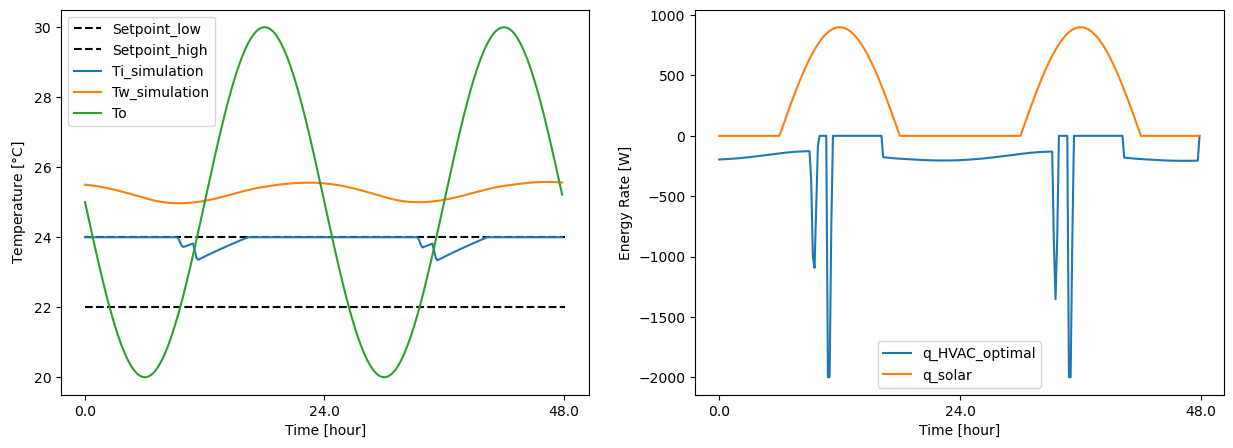

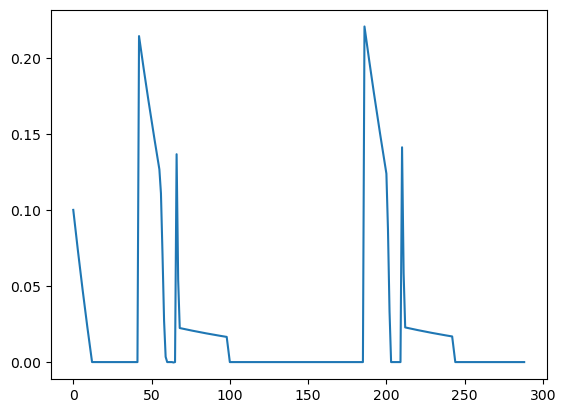

In [37]:
N = x.shape[0]
Ti_simulation = x[:,0] # Indoor temperature 
Tw_simulation = x[:,1]

u_HVAC = v[:,0]*1000 # [W]
e_BH = v[:,1] # [kW]
e_GB = v[:,2] # [kW]

# plotting
t_span = np.arange(0,N+1)
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].hlines(setpoint_low, 0, N, label='Setpoint_low', linestyle='--', color='k')
ax[0].hlines(setpoint_high, 0, N, label='Setpoint_high', linestyle='--', color='k')

ax[0].plot(Ti_simulation[:-1], label='Ti_simulation')
ax[0].plot(Tw_simulation[:-1], label='Tw_simulation')
ax[0].plot(To, label='To')
ax[0].set_xticks(t_span[::6*24],t_span[::6*24]*10/60)
ax[0].set_ylabel('Temperature [$\degree$C]')
ax[0].set_xlabel('Time [hour]')
ax[0].legend()

ax[1].plot(u_HVAC, label='q_HVAC_optimal')
ax[1].plot(q_solar, label='q_solar')
ax[1].set_xticks(t_span[::6*24],t_span[::6*24]*10/60)
ax[1].set_ylabel('Energy Rate [W]')
ax[1].set_xlabel('Time [hour]')
ax[1].legend()

plt.show()

plt.plot(E)

In [38]:
print('Electricity cost: $', np.sum((-u_HVAC/1000/COP - e_BH + e_GB)/6 * price))

Electricity cost: $ 0.1973317695934889


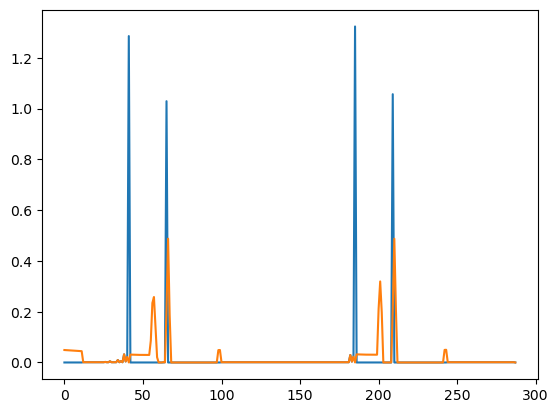

In [39]:
plt.plot(e_GB)
plt.plot(e_BH)

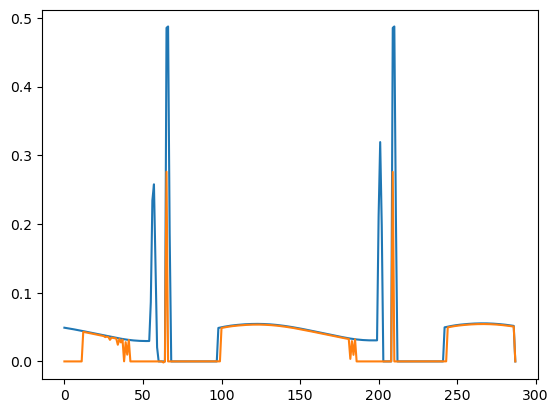

In [40]:
plt.plot(-u_HVAC/1000/COP)
plt.plot(-u_HVAC/1000/COP - e_BH)

In [41]:
(-u_HVAC/1000/COP).sum()/6

2.149365487368811